In [1]:
import os
import torch
import torchvision
from torch.utils.data import random_split

data_dir = 'Dataset/'
classes = os.listdir(data_dir)
print(classes)

a_files = os.listdir(data_dir + "a")
print('No. of training examples for a:', len(a_files))

['a', 'b', 'c', 'ch', 'e', 'f', 'g', 'i', 'k', 'kh', 'l', 'm', 'n', 'o', 'p', 'r', 's', 'sh', 't', 'u', 'v', 'ya', 'ye', 'yi', 'yu', 'zh']
No. of training examples for a: 20


In [2]:
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torchvision import transforms

imagenet_stats = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
transform = transforms.Compose([
    transforms.Resize((224, 224), interpolation=3),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(*imagenet_stats)])

dataset = ImageFolder(data_dir, transform)

Label: a (0)


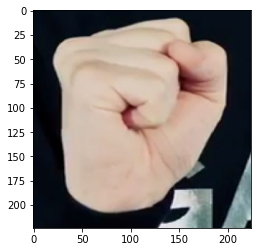

In [3]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams['figure.facecolor'] = '#ffffff'

def denormalize(images, means, stds):
    if len(images.shape) == 3:
        images = images.unsqueeze(0)
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)
    return images * stds + means

def show_image(img_tensor, label):
    print('Label:', dataset.classes[label], '(' + str(label) + ')')
    img_tensor = denormalize(img_tensor, *imagenet_stats)[0].permute((1, 2, 0))
    plt.imshow(img_tensor)
    
show_image(*dataset[2])

In [4]:
val_size = 64
train_size = len(dataset) - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

from torch.utils.data.dataloader import DataLoader

batch_size=32
train_dl = DataLoader(train_ds, batch_size, shuffle=True, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size, pin_memory=True)

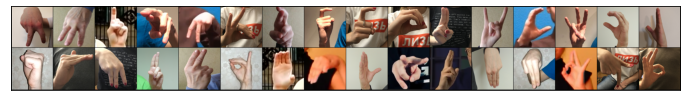

In [5]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        images = denormalize(images[:64], *imagenet_stats)
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break
        
show_batch(train_dl)

In [6]:
import torch.nn as nn
import torch.nn.functional as F

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))


class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels)  # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}],{} train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, "last_lr: {:.5f},".format(result['lrs'][-1]) if 'lrs' in result else '', 
            result['train_loss'], result['val_loss'], result['val_acc']))


In [7]:
from torchvision import models

class ModelX(ImageClassificationBase):
    def __init__(self, num_classes, pretrained=True):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet50(pretrained=pretrained)
        # Replace last layer
        self.network.fc = nn.Linear(self.network.fc.in_features, num_classes)

    def forward(self, xb):
        return self.network(xb)

In [8]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')


def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)


class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""

    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [9]:
import torch
from tqdm.notebook import tqdm

@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)


def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader,
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []

    # Set up custom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs,
                                                steps_per_epoch=len(train_loader))

    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        lrs = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()

            # Gradient clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            optimizer.zero_grad()

            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()

        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [10]:
device = get_default_device()

train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(val_dl, device)

In [15]:
model = ModelX(len(dataset.classes))
to_device(model, device);

In [16]:
history = [evaluate(model, valid_dl)]
history

[{'val_loss': 3.3287158012390137, 'val_acc': 0.03125}]

In [17]:
epochs = 30
max_lr = 0.001
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [18]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl, 
                         grad_clip=grad_clip, 
                         weight_decay=weight_decay, 
                         opt_func=opt_func)


Epoch [0],last_lr: 0.00007, train_loss: 3.2339, val_loss: 3.0706, val_acc: 0.1250



Epoch [1],last_lr: 0.00015, train_loss: 2.5173, val_loss: 2.3016, val_acc: 0.3281



Epoch [2],last_lr: 0.00027, train_loss: 1.5144, val_loss: 1.5028, val_acc: 0.5781



Epoch [3],last_lr: 0.00043, train_loss: 0.6691, val_loss: 1.1384, val_acc: 0.6250



Epoch [4],last_lr: 0.00060, train_loss: 0.5665, val_loss: 2.0015, val_acc: 0.5156



Epoch [5],last_lr: 0.00076, train_loss: 0.9823, val_loss: 3.1948, val_acc: 0.3281



Epoch [6],last_lr: 0.00089, train_loss: 1.1277, val_loss: 4.4959, val_acc: 0.2031



Epoch [7],last_lr: 0.00097, train_loss: 1.0664, val_loss: 5.9744, val_acc: 0.2969



Epoch [8],last_lr: 0.00100, train_loss: 0.9983, val_loss: 4.5835, val_acc: 0.2344



Epoch [9],last_lr: 0.00099, train_loss: 0.7766, val_loss: 1.7023, val_acc: 0.5000



Epoch [10],last_lr: 0.00098, train_loss: 0.6339, val_loss: 1.4755, val_acc: 0.6406



Epoch [11],last_lr: 0.00095, train_loss: 0.5171, val_loss: 1.7420, val_acc: 0.5781



Epoch [12],last_lr: 0.00091, train_loss: 0.3525, val_loss: 1.3380, val_acc: 0.5781



Epoch [13],last_lr: 0.00087, train_loss: 0.4000, val_loss: 1.0731, val_acc: 0.6875



Epoch [14],last_lr: 0.00081, train_loss: 0.2883, val_loss: 1.3229, val_acc: 0.5938



Epoch [15],last_lr: 0.00075, train_loss: 0.2311, val_loss: 0.9436, val_acc: 0.7656



Epoch [16],last_lr: 0.00068, train_loss: 0.1498, val_loss: 0.8345, val_acc: 0.7500



Epoch [17],last_lr: 0.00061, train_loss: 0.1247, val_loss: 0.7922, val_acc: 0.7344



Epoch [18],last_lr: 0.00054, train_loss: 0.0651, val_loss: 0.6565, val_acc: 0.7969



Epoch [19],last_lr: 0.00046, train_loss: 0.0330, val_loss: 0.6757, val_acc: 0.8125



Epoch [20],last_lr: 0.00039, train_loss: 0.0258, val_loss: 0.5380, val_acc: 0.8438



Epoch [21],last_lr: 0.00032, train_loss: 0.0326, val_loss: 0.5114, val_acc: 0.8125



Epoch [22],last_lr: 0.00025, train_loss: 0.0122, val_loss: 0.6166, val_acc: 0.8125



Epoch [23],last_lr: 0.00019, train_loss: 0.0092, val_loss: 0.5793, val_acc: 0.7969



Epoch [24],last_lr: 0.00013, train_loss: 0.0120, val_loss: 0.4813, val_acc: 0.8750



Epoch [25],last_lr: 0.00009, train_loss: 0.0080, val_loss: 0.5665, val_acc: 0.8281



Epoch [26],last_lr: 0.00005, train_loss: 0.0538, val_loss: 0.4871, val_acc: 0.8594



Epoch [27],last_lr: 0.00002, train_loss: 0.0178, val_loss: 0.4251, val_acc: 0.8594



Epoch [28],last_lr: 0.00001, train_loss: 0.0098, val_loss: 0.4700, val_acc: 0.8594



Epoch [29],last_lr: 0.00000, train_loss: 0.0143, val_loss: 0.4592, val_acc: 0.8594
Wall time: 10min 5s


## resnet34 - epochs = 15 - max_lr = 0.01 - val_acc: 0.6719
## resnet34 - epochs = 15 - max_lr = 0.001 - val_acc: 0.8281
## resnet50 - epochs = 15 - max_lr = 0.0025 - val_acc: 0.7203
## resnet50 - epochs = 30 - max_lr = 0.001 - val_acc: 0.8594